# Visualizing Illinois:
Including none cleaned:
* approved state senate plan districts
* approved congressional districts

@authors: vcle, bpuhani

## Loading needed libraries

In [1]:
import sys
import time
import warnings
import io

import maup
import pandas as pd
from matplotlib import pyplot as plt

import utilities as util

import networkx as nx
from gerrychain import Graph, GeographicPartition


In [2]:
maup.progress.enabled = False

warnings.filterwarnings('ignore')

start_time = time.time()

### configuration to capture print output
original_stdout = sys.stdout

## Downloading the data

All data retrieved in April 2025: <br>
| **Dataset**                                                                                                        | **Description**                                                                           | **Metadata**                                                                                      |
|--------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| [2021 State Senate District plan](https://redistrictingdatahub.org/dataset/2021-oregon-state-senate-adopted-plan/) | 2021 Illinois State Senate Approved Plan                                                  | [Link](https://redistrictingdatahub.org/wp-content/uploads/2021/12/readme_il_sldu_2021.txt)       |
| [2021 Congressional District plan](https://redistrictingdatahub.org/dataset/2021-illinois-congressional-districts-approved-plan/) | 2021 Illinois Congressional Districts                                                     | [Link](https://redistrictingdatahub.org/wp-content/uploads/2021/11/readme_il_cong_adopted_2021.txt)        |

## Loading the needed data.
This notebook requires running:
* `0_IL_import_and_explore_data.ipynb`
* `1_IL_clean_maup.ipynb`

before this one.

In [3]:
# Paths to the data
sen_path = "il_data/il_sldu_2021/il_sldu_2021.shp"
vest20_path = "il_data/il_vest_20/il_vest_20.shp"
cong_path = "il_data/il_cong_adopted_2021/HB 1291 FA #1.shp"
assembled_path = "il_data/IL.shp"

In [4]:
sen_df = util.load_shapefile(sen_path)

vest20_df = util.load_shapefile(vest20_path)

assembled_df = util.load_shapefile(assembled_path)

# cong_df = util.load_shapefile(cong_path) # throws error

Loading shapefile from il_data/il_sldu_2021/il_sldu_2021.shp...
Shapefile data loaded from cache.
Loading shapefile from il_data/il_vest_20/il_vest_20.shp...
Shapefile data loaded from cache.
Loading shapefile from il_data/IL.shp...
Shapefile data loaded from cache.


In [5]:
try:
    print(maup.doctor(sen_df))
except Exception as e:
    print(f"Error in MAUP Doctor for sen_df: {e}")

True


In [6]:
# we know that Illinois has 59 districts
nr_of_districts = len(set(sen_df["DISTRICTN"]))
assert (nr_of_districts == 59), f"Number of districts in Illinois: {nr_of_districts} != 59"

districts_with_issues = {}

# Create a StringIO object to capture the output
captured_output = io.StringIO()

for district in set(sen_df["DISTRICTN"]):
    district_df = sen_df[sen_df["DISTRICTN"] == district]
    print("Checking district: ", district)
    success: bool = False
    output: str = ""

    try:
        # Redirect stdout to the StringIO object
        sys.stdout = captured_output

        try:
            # maup.doctor(district_df) will return True if there are no issues
            success = maup.doctor(district_df)
        except Exception as e:
            print(f"Error in MAUP Doctor for district {district}: {e}")

        # Get the captured output as a string without new lines
        output = captured_output.getvalue().replace("\n", "")

    finally:
        # Restore the original stdout
        sys.stdout = original_stdout
        captured_output.truncate(0) # Clear the StringIO buffer
        captured_output.seek(0) # Reset the cursor to the beginning
        if not success:
            print(f"Problem in district {district}: {output}")
            districts_with_issues[district] = output

captured_output.close()

Checking district:  1
Checking district:  2
Checking district:  3
Checking district:  4
Checking district:  5
Checking district:  6
Checking district:  7
Checking district:  8
Checking district:  9
Checking district:  10
Checking district:  11
Checking district:  12
Checking district:  13
Checking district:  14
Checking district:  15
Checking district:  16
Checking district:  17
Checking district:  18
Checking district:  19
Checking district:  20
Checking district:  21
Checking district:  22
Checking district:  23
Checking district:  24
Checking district:  25
Checking district:  26
Checking district:  27
Checking district:  28
Checking district:  29
Checking district:  30
Checking district:  31
Checking district:  32
Checking district:  33
Checking district:  34
Checking district:  35
Checking district:  36
Checking district:  37
Checking district:  38
Checking district:  39
Checking district:  40
Checking district:  41
Checking district:  42
Checking district:  43
Checking district:  

In [7]:
print("There are a total of", len(districts_with_issues), "districts with issues.")

There are a total of 0 districts with issues.


## Lets try to check if there are any disconnected precincts inside the vest20_df

In [8]:
vest20_df.head()

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREACAR,G20PRESLAR,G20USSDDUR,G20USSRCUR,G20USSIWIL,G20USSLMAL,G20USSGBLA,geometry
0,17,019,CN0100,17019CN0100,Cunningham 1,753,62,7,9,2,5,684,51,70,12,15,"POLYGON ((-88.23247 40.13302, -88.23175 40.134..."
1,17,019,CC0600,17019CC0600,City of Champaign 06,1035,264,16,16,4,4,958,253,56,21,35,"POLYGON ((-88.25798 40.13331, -88.25798 40.134..."
2,17,019,CC0100,17019CC0100,City of Champaign 01,590,34,2,2,1,6,532,28,58,5,4,"POLYGON ((-88.24012 40.11728, -88.24012 40.117..."
3,17,019,CC0900,17019CC0900,City of Champaign 09,618,98,6,8,2,1,578,84,37,15,14,"POLYGON ((-88.27716 40.13611, -88.27702 40.136..."
4,17,019,CC0300,17019CC0300,City of Champaign 03,1073,209,28,9,3,6,1007,232,10,35,18,"POLYGON ((-88.23540 40.11265, -88.23359 40.112..."


In [9]:
il_graph = Graph.from_file(vest20_path)

In [10]:
print("Is this dual graph connected? ", nx.is_connected(il_graph))
print("Is this dual graph planar? ", nx.is_planar(il_graph))
print("Number of Nodes: ", len(il_graph.nodes()))
print("Number of Edges: ", len(il_graph.edges()))

Is this dual graph connected?  True
Is this dual graph planar?  False
Number of Nodes:  10083
Number of Edges:  28228


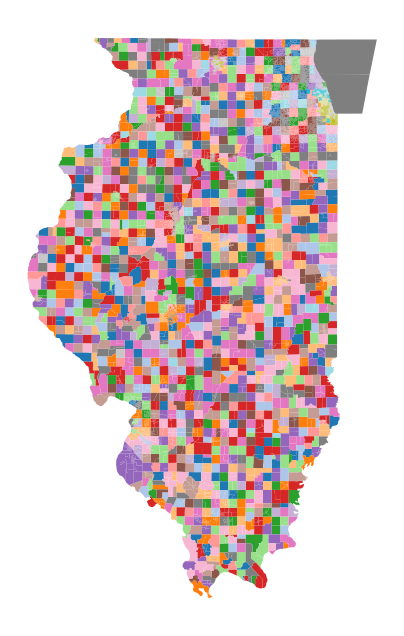

In [11]:
initial_partition = GeographicPartition(il_graph, assignment= "NAME20")
vest20_df.plot(pd.Series([initial_partition.assignment[i] for i in vest20_df.index]), cmap="tab20", figsize=(16,8))
plt.axis('off')
plt.show()

In [12]:
# are there any disconnected precincts?
disconnected_nodes = [node for node in il_graph.nodes() if il_graph.degree(node) == 0]
print("Disconnected nodes: ", disconnected_nodes)

Disconnected nodes:  []


## Try to check if there are any disconnected districts in the cleaned and assembled vest20_df `assembled_df`

In [13]:
il_graph = Graph.from_file(assembled_path)

In [14]:
print("Is this dual graph connected? ", nx.is_connected(il_graph))
print("Is this dual graph planar? ", nx.is_planar(il_graph))
print("Number of Nodes: ", len(il_graph.nodes()))
print("Number of Edges: ", len(il_graph.edges()))

Is this dual graph connected?  True
Is this dual graph planar?  False
Number of Nodes:  10083
Number of Edges:  27863


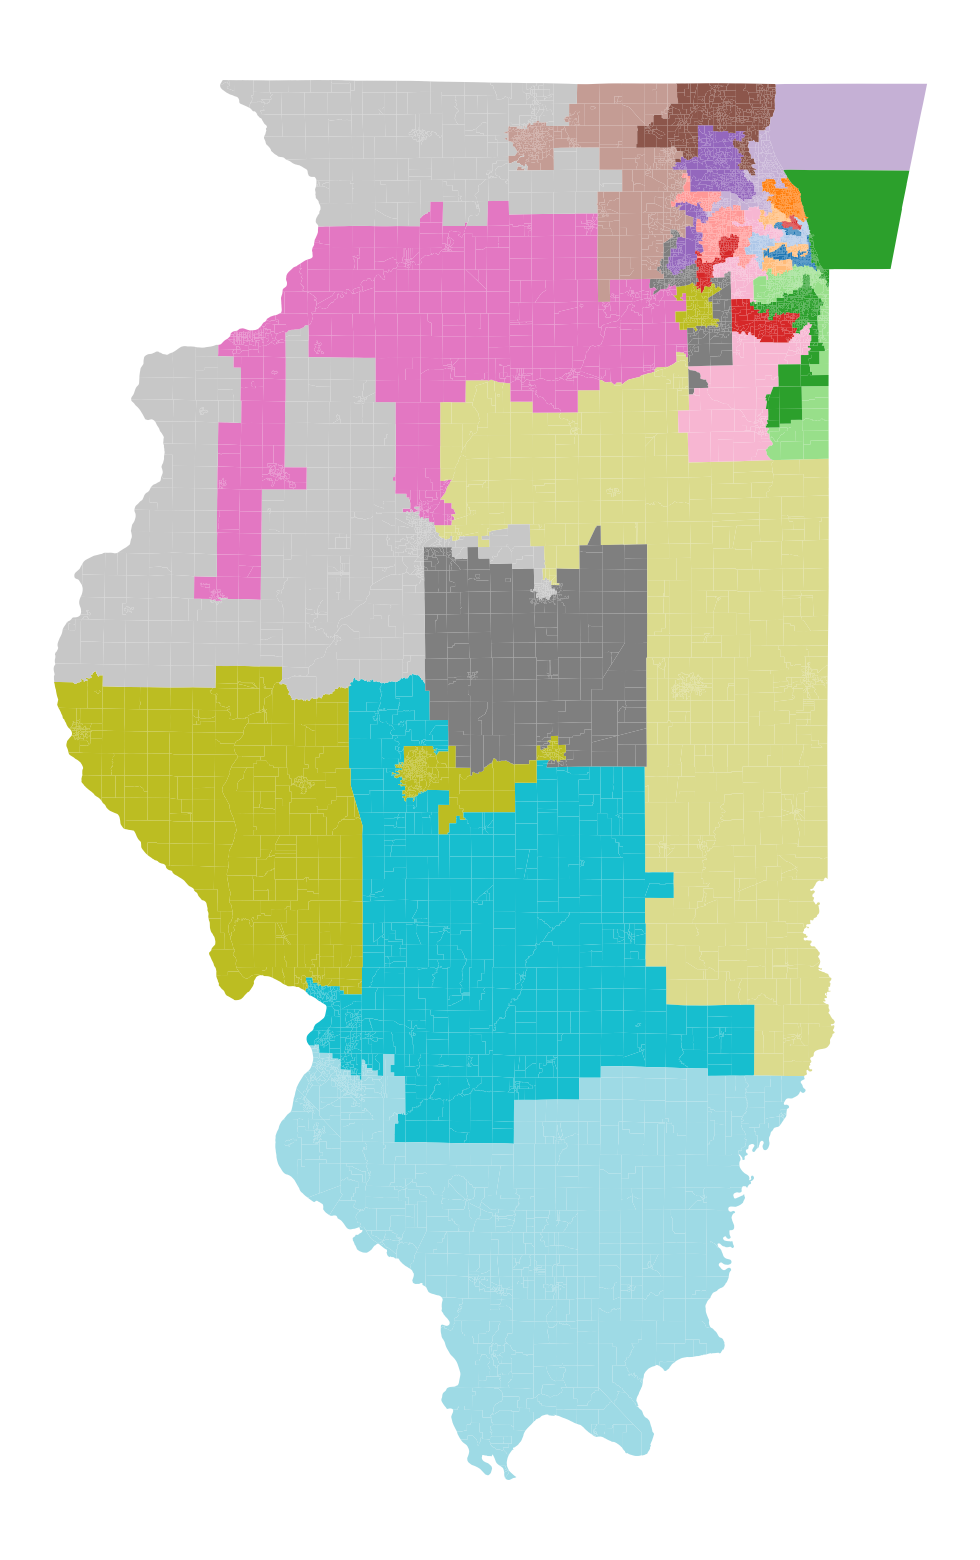

In [15]:
initial_partition = GeographicPartition(il_graph, assignment= "SEND")
vest20_df.plot(pd.Series([initial_partition.assignment[i] for i in vest20_df.index]), cmap="tab20", figsize=(20,20))
plt.axis('off')
plt.show()

In [16]:
# There are no disconnected nodes in the big graph
disconnected_nodes = [node for node in il_graph.nodes() if il_graph.degree(node) == 0]
print("Disconnected nodes: ", disconnected_nodes)

Disconnected nodes:  []


Now lets try it district for district

Checking district:  1
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  116
Number of Edges:  256
Checking district:  2
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  157
Number of Edges:  366
Checking district:  3
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  145
Number of Edges:  325
Checking district:  4
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  164
Number of Edges:  376
Checking district:  5
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  170
Number of Edges:  411
Checking district:  6
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  160
Number of Edges:  368
Checking district:  7
Is this dual graph connected?  True
Is this dual graph planar?  True
Number of Nodes:  155
Number of Edges:  364
Checking district:  8
Is this dual graph connected?  Tr

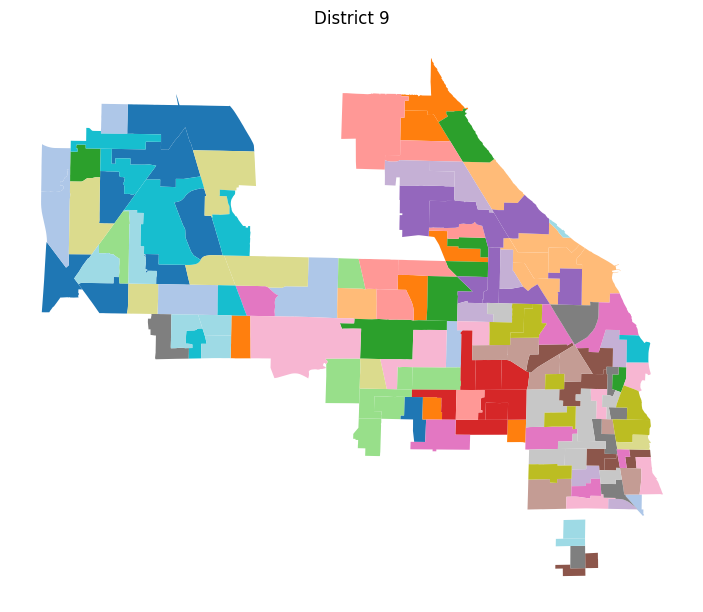

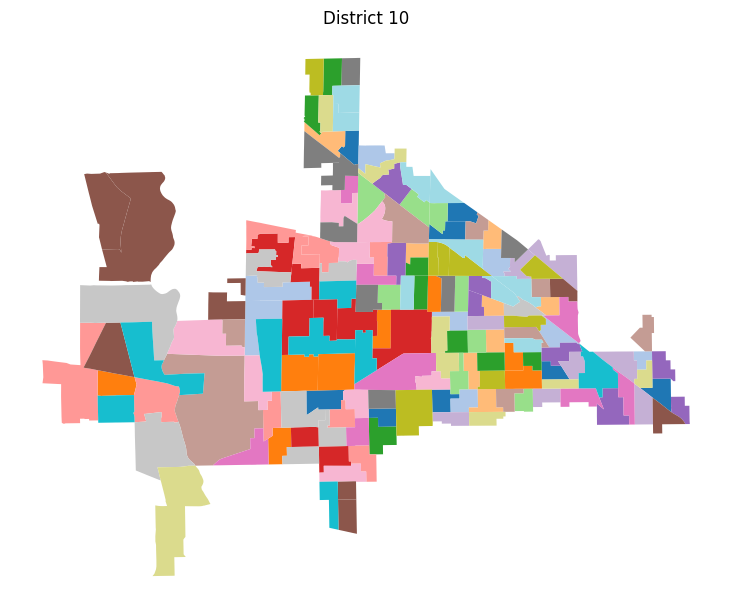

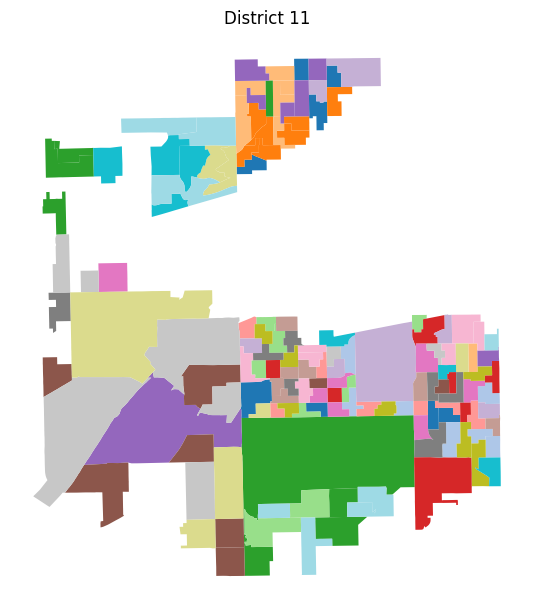

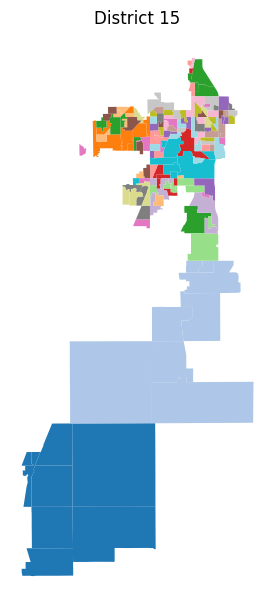

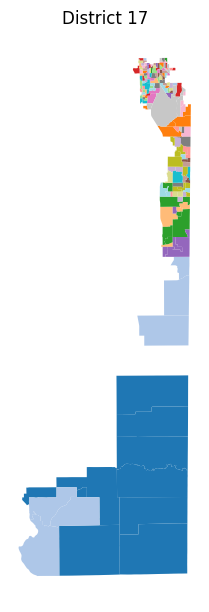

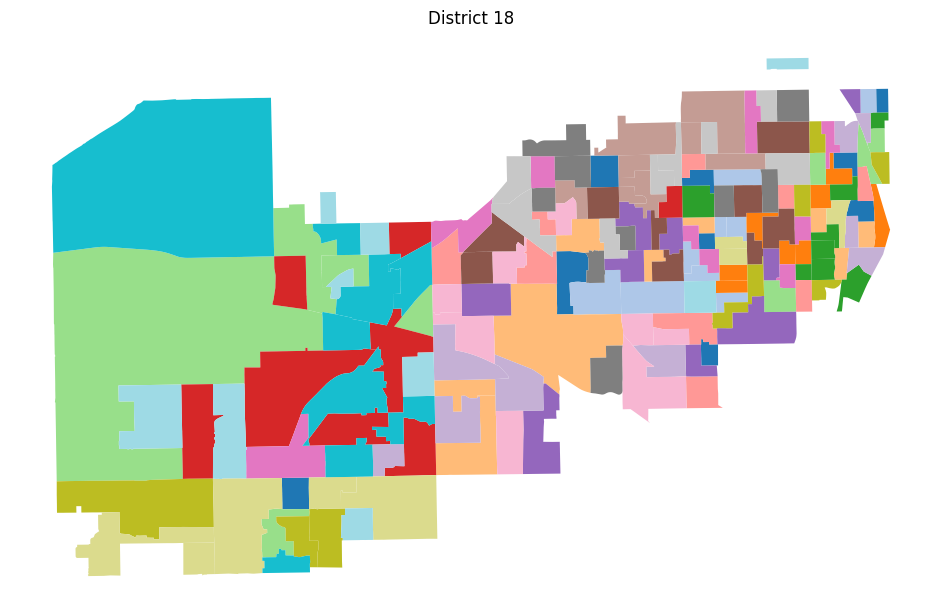

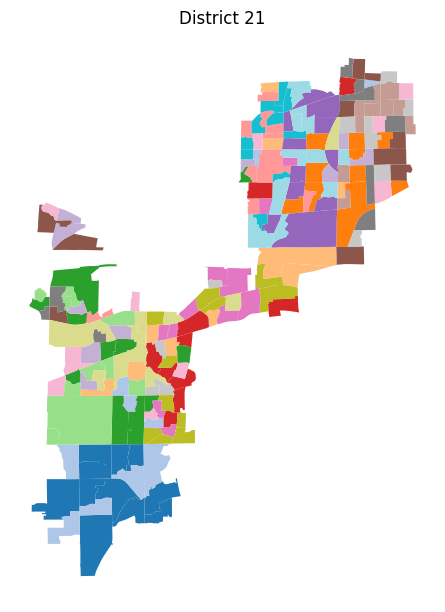

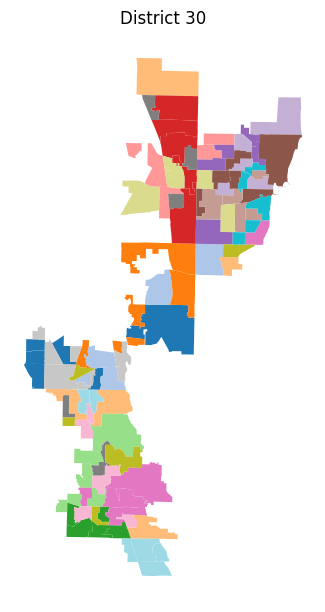

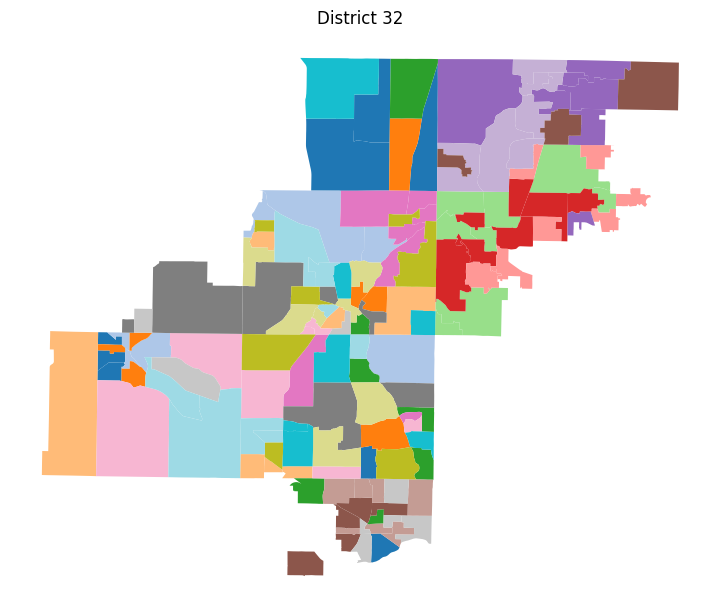

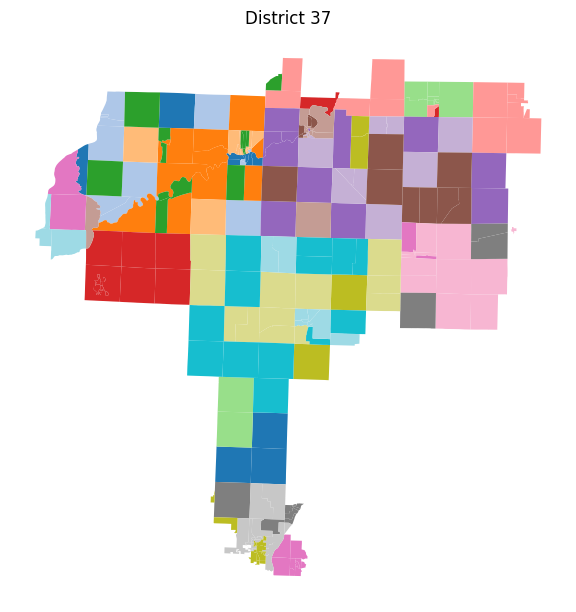

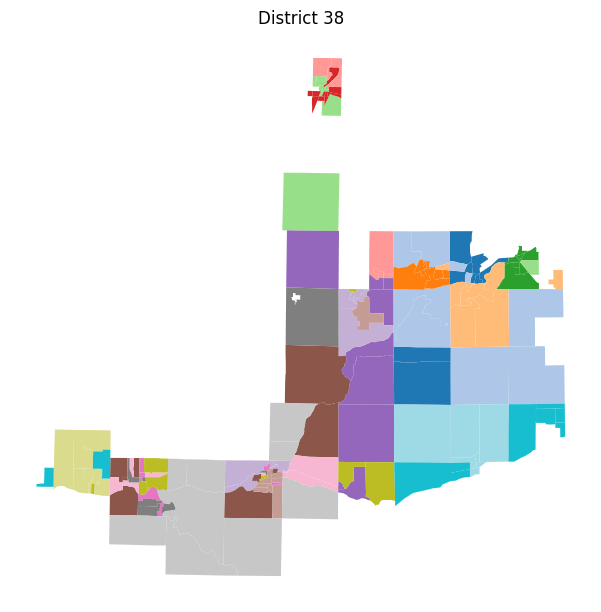

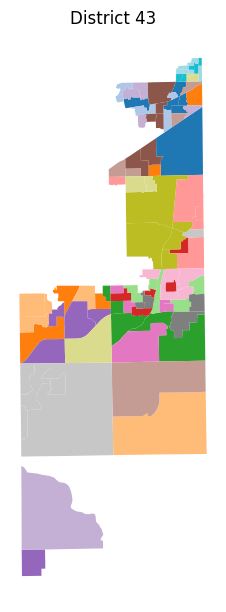

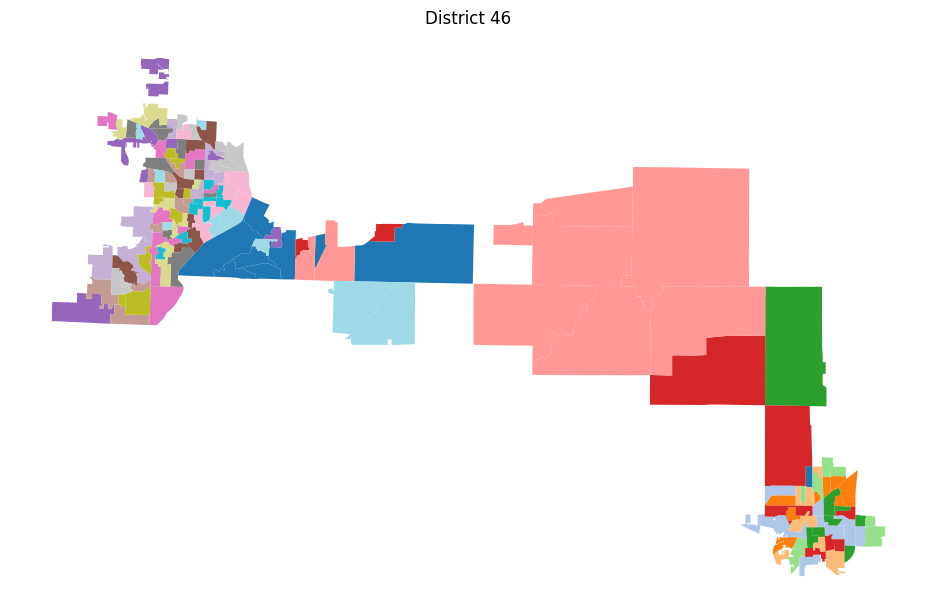

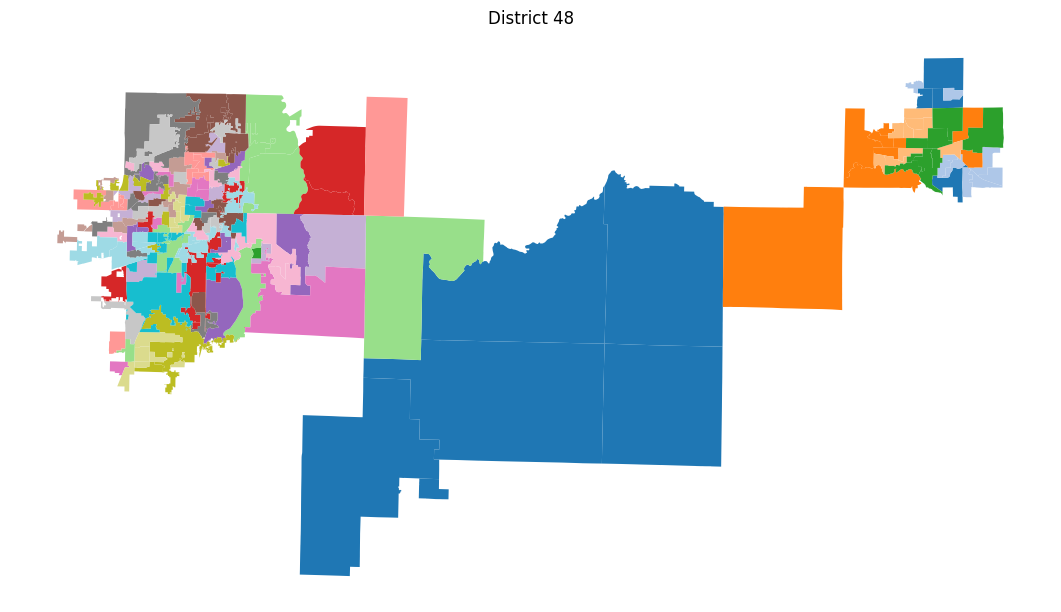

In [21]:
counter_for_disconnected = 0

for district in set(assembled_df["SEND"]):
    district_df = assembled_df[assembled_df["SEND"] == district]
    print("Checking district: ", district)
    il_district_graph = Graph.from_geodataframe(district_df)

    # check if the graph is connected
    print("Is this dual graph connected? ", nx.is_connected(il_district_graph))
    print("Is this dual graph planar? ", nx.is_planar(il_district_graph))
    print("Number of Nodes: ", len(il_district_graph.nodes()))
    print("Number of Edges: ", len(il_district_graph.edges()))

    # draw if the graph is not connected
    if not nx.is_connected(il_district_graph):
        counter_for_disconnected += 1
        print(f"District: {district} is not connected")
        district_df.plot(cmap="tab20", figsize=(12,6))
        plt.axis('off')
        plt.tight_layout()
        plt.title(f"District {district}")

In [22]:
print("Total number of disconnected districts: ", counter_for_disconnected)

NameError: name 'counter_for_disconnected' is not defined